## Function definition

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import imutils
import math
from scipy.interpolate import RegularGridInterpolator
import time
from PIL import Image

def eucl_dist(p):
    return np.sqrt(np.square(p[0, :])+ np.square(p[1, :]))

def delta_r(p, dist):
    p = eucl_dist(p)
    return dist[0]*p**2 + dist[1]*p**4 + dist[2]*p**8

def radial_dist(p, dist):
    return p*(1+delta_r(p, dist))

def box3d(n):
    x = []
    y = []
    z = []

    for i, val in enumerate([-0.5, -0.5, 0, 0.5, 0.5], 1):
        x = np.concatenate((x, val*np.ones(n)))
        y = np.concatenate((y, np.linspace(-0.5, 0.5, n)))
        z = np.concatenate((z, (2*(i % 2)-1)*val*np.ones(n)))
    x2 = np.concatenate((x, y))
    x2 = np.concatenate((x2, x))
    y2 = np.concatenate((y, z))
    y2 = np.concatenate((y2, z))
    z2 = np.concatenate((z, x))
    z2 = np.concatenate((z2, y))
    return np.vstack((x2, y2, z2))


def projectpoints(K, R, t, Q):
    #ret = K@np.concatenate((R, t))@np.hstack((P, 1))
    ret = K@np.hstack((R, t))@np.vstack((Q, np.ones(len(Q[0]))))
    return ret[0:2, :]/ret[2, :]

def projectpoints2(K, R, t, Q, dist):

    RtQ_homo = np.hstack((R, t))@np.vstack((Q, np.ones(len(Q[0]))))
    RtQ_inhomo = RtQ_homo[0:2, :]/RtQ_homo[2, :]
    rad_dist = radial_dist(RtQ_inhomo, dist)
    rad_dist_homo = np.vstack((rad_dist, np.ones(len(rad_dist[0]))))
    return K@rad_dist_homo

## Exercise 2.1
Adding soem extra parameters to camera matrix (alpha, beta, delta_x, delta_y)

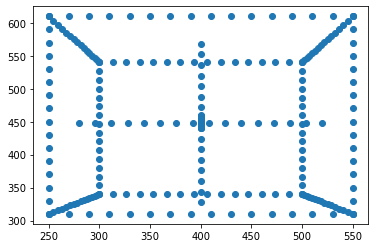

In [2]:
Q = box3d(16)
f = 600
alpha = 1
beta = 0
delta_x = delta_y = 400
K = np.array([[f, beta*f, delta_x], [0, alpha*f, delta_y], [0, 0, 1]])
R = np.identity(3)
t = np.array([[0, 0.2, 2.5]]).T
camera = projectpoints(K, R, t, Q)
plt.scatter(camera[0], camera[1])
plt.show()
# y = distance from the object
# z = distance from the object into the table
# x = distance to left

## Exercise 2.2
Implementing distortino function

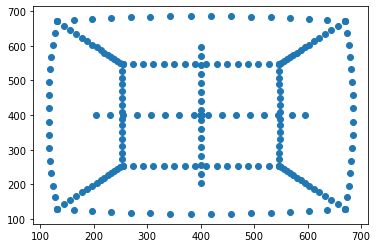

In [3]:
Q = box3d(16)
f = 600
alpha = 1
beta = 0
delta_x = delta_y = 400
K = np.array([[f, beta*f, delta_x], [0, alpha*f, delta_y], [0, 0, 1]])
R = np.identity(3)
t = np.array([[0, 0, 1.5]]).T
k3 = -0.2
k5 = 0
k7 = 0
dist = np.array([k3, k5, k7])
camera = projectpoints2(K, R, t, Q, dist)
plt.scatter(camera[0], camera[1])
plt.show()

## Exercise 2.3
Finding the camera matrix for the gopro image.

In [11]:
image = cv2.imread("gopro_robot.jpg")
new_image = np.zeros(image.shape)
image = cv2.resize(image, (480, 270))
new_image = cv2.resize(new_image, (480, 270))
(h, w, d) = image.shape

delta_x = w/2  # principal point should be in the middle
delta_y = h/2
alpha = 1
beta = 0
f = 0.455732 * w
K = np.array([[f, beta*f, delta_x], [0, alpha*f, delta_y], [0, 0, 1]])
print("Camera Matrix")
print(K)

Camera Matrix
[[218.75136   0.      240.     ]
 [  0.      218.75136 135.     ]
 [  0.        0.        1.     ]]


## Exercise 2.4
This one was the most tricky. Firstly I misunderstood that we actually have the pixels, not the position in meters, so I wrongly implemented it to the opposite side of the equation. to get the results, there are two options.
1) Inverse the whole logic of the equation which is used for computing the distorin (which includes inversing the dist() function. It might be working, but it would take ages to do it. Therefore the more clever idea is probably the next option
2) Use bilinear interpolation by running scipy.interpolate.RegularGridInterpolator. Havent tried yet, but might give a try later. Nevertheless, its just premade function which wont give much of the value to implement. Its more likely just about finding the right arguments in the function call...

240 -54468944


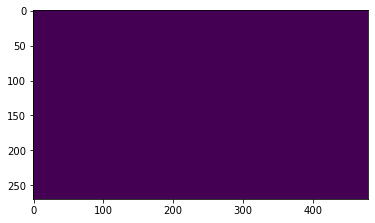

In [15]:
# This is compeltely wrong approach, but since it cost me like 2 hours of my life, I will just leave it here
image = cv2.imread("gopro_robot.jpg")
#new_img = Image.new('RGB', (w, h), (0, 0, 0))
new_image = np.zeros(image.shape[:2])
image = cv2.resize(image, (480, 270))
new_image = cv2.resize(new_image, (480, 270))
(h, w, d) = image.shape

delta_x = w/2  # principal point should be in the middle
delta_y = h/2
alpha = 1
beta = 0
K = np.array([[f, beta*f, delta_x], [0, alpha*f, delta_y], [0, 0, 1]])
R = np.identity(3)
t = np.array([[0, 0, 10]]).T
f = 0.455732*1920
k3 = -0.245031
k5 = 0.071524
k7 = -0.00994978
dist = np.array([k3, k5, k7])

camera = projectpoints2(K, R, t, np.array([[0],[425],[54]]),dist)
print(int(camera[0][0]),int(camera[1][0]))
plt.imshow(new_image)

This is the working code by Juliette.
To use it, you make a grid of the coordinates that you want to query. That's the fun part. 
I ended up in blood and tears over this (only half of the exercises left now lol... I was hoping every week would be like the first) so I can be empathic and send the whole function if you need it X)
I'll ask a TA next week about my bug, I don't have the will to keep trying to understand what happens

In [16]:
Image = cv2.imread("gopro_robot.jpg")
n = Image.shape[0]
m = Image.shape[1]
points = (np.arange(0, n), np.arange(0, m))
I = Image[:, :, 0]

interpolating_function = RegularGridInterpolator(
  points,
  values=I,
  method="nearest",
  bounds_error=False,
  fill_value=0
)

## Exercise 2.5
* Map the points p_i using the homography points p_1 -> p_4 on a plane
* q1 = H*q2

In [183]:
def homography_point(H,q):
    q_ret = H@q
    p_ret = q_ret[0:2, :]/q_ret[2, :]
    print ("q_inhomo", p_ret)
    return p_ret #inhomogeneous

H = np.array([[-2,0,1],[1,-2,0],[0,0,3]])
q1_1 = np.array([[1, 1, 1]]).T #first point, original image
q1_2 = np.array([[0, 3, 1]]).T
q1_3 = np.array([[2, 3, 1]]).T
q1_4 = np.array([[2, 4, 1]]).T
q2_1 = np.vstack((homography_point(H,q1_1),1)) #first point, result image (after applying H)
q2_2 = np.vstack((homography_point(H,q1_2),1))
q2_3 = np.vstack((homography_point(H,q1_3),1))
q2_4 = np.vstack((homography_point(H,q1_4),1))
# q2_1 = homography_point(H,q1_1)
# q2_2 = homography_point(H,q1_2)
# q2_3 = homography_point(H,q1_3)
# q2_4 = homography_point(H,q1_4)


q_inhomo [[-0.33333333]
 [-0.33333333]]
q_inhomo [[ 0.33333333]
 [-2.        ]]
q_inhomo [[-1.        ]
 [-1.33333333]]
q_inhomo [[-1.]
 [-2.]]


## Exercise 2.6
- Function hest, arg 2 sets of (q1 and q2), return estimated homography matrix
- we need at least 4 pairs of points to estimate homography
- https://learnopencv.com/homography-examples-using-opencv-python-c/
- SVD is finding the eigenvector with the smallest eigenvalue
- The solution of Ax = 0 where ||x||2 = 1 is found using SVD. x = v where the singular vector corresponds to the smallest singular value.
- matrix B is A in SVD
- flatten(H) is x in SVD
- we try to find x, which we transform into H

In [224]:
def hest(q1,q2):
    #q1 = [[x10_result, x11_result][y10_result, y11_result]] #first number which q, second which column
    #q2 = [[x20_original, x21_original],[y20_original, y21_original]]
    #q1 = H@q2
    assert len(q1[0])>1, "We need at least two points (aka two columns)"
    assert len(q1[0])==len(q2[0]), "Number of column of q1 and q2 must be equal!"
    B = get_b(q1,q2)#np.vstack((B0,B1))
    print("B")
    print(B.round(1)) # does not matter whether there is 1 or 3 in the top right 3x3 matrix
    U,S,VT = np.linalg.svd(B.T@B) #U,S,VT = np.linalg.svd(np.hstack((B.T,B)))
    H = np.reshape(VT[-1],(3,3)) # VT is sorted in descending order of singular value
    print("H",H.T.round(2))

def get_b(q1,q2):
    B = np.kron(q2[:,0], np.array([[0,-1,q1[1,0]],[1,0,-q1[0,0]],[-q1[1,0],q1[0,0],0]]))
    for i in range(1,len(q1[0])):
        B_temp = np.kron(q2[:,i], np.array([[0,-1,q1[1,i]],[1,0,-q1[0,i]],[-q1[1,i],q1[0,i],0]]))
        B = np.vstack((B,B_temp))
    return B

q1 = np.hstack((q1_1,q1_2,q1_3,q1_4))
q2 = np.hstack((q2_1,q2_2,q2_3,q2_4))

print("q1")
print(q1)
print("q2")
print(q2)
hest(q1,q2)

q1
[[1 0 2 2]
 [1 3 3 4]
 [1 1 1 1]]
q2
[[-0.33333333  0.33333333 -1.         -1.        ]
 [-0.33333333 -2.         -1.33333333 -2.        ]
 [ 1.          1.          1.          1.        ]]
B
[[-0.   0.3 -0.3 -0.   0.3 -0.3  0.  -1.   1. ]
 [-0.3 -0.   0.3 -0.3 -0.   0.3  1.   0.  -1. ]
 [ 0.3 -0.3 -0.   0.3 -0.3 -0.  -1.   1.   0. ]
 [ 0.  -0.3  1.  -0.   2.  -6.   0.  -1.   3. ]
 [ 0.3  0.   0.  -2.  -0.  -0.   1.   0.   0. ]
 [-1.   0.   0.   6.  -0.  -0.  -3.   0.   0. ]
 [-0.   1.  -3.  -0.   1.3 -4.   0.  -1.   3. ]
 [-1.  -0.   2.  -1.3 -0.   2.7  1.   0.  -2. ]
 [ 3.  -2.  -0.   4.  -2.7 -0.  -3.   2.   0. ]
 [-0.   1.  -4.  -0.   2.  -8.   0.  -1.   4. ]
 [-1.  -0.   2.  -2.  -0.   4.   1.   0.  -2. ]
 [ 4.  -2.  -0.   8.  -4.  -0.  -4.   2.   0. ]]
H [[-0.59  0.    0.2 ]
 [-0.3  -0.59  0.1 ]
 [-0.    0.    0.4 ]]


## Exercise 2.7
- function normalize2d that finds transformation T such that q_ih = T@p_ih has mean [0,0] and standard deviation [1,1] for all q_i

In [225]:
def normalize2d(q):
    #create NumPy array
    q_ret = np.empty((3,0),float)
    for i in range (0,len(q[0])):
        q_temp = np.array([q[:,i]])
        if (q_temp.max() - q_temp.min())==0: #problem with division by 0
            q_norm = q_temp
        else:
            q_norm = (q_temp - q_temp.min())/ (q_temp.max() - q_temp.min())
        q_ret = np.hstack((q_ret,q_norm.T))
    return q_ret

q_res = normalize2d(q1) #normalize all values in array
print(q_res)

# we should use it on inhomogeneous point and I am using it on homogeneous
# but if I use it on inhomogeneous point, for q1 in last free columns result
# into the same point, which is nonsense...


[[1.         0.         0.5        0.33333333]
 [1.         1.         1.         1.        ]
 [1.         0.33333333 0.         0.        ]]
